In [1]:
from sklearn.preprocessing import StandardScaler
from scipy.stats import boxcox, probplot, norm
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
# https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff
# https://www.geeksforgeeks.org/python-how-and-where-to-apply-feature-scaling/
# https://medium.com/fintechexplained/ever-wondered-why-normal-distribution-is-so-important-110a482abee3
# https://towardsdatascience.com/understanding-boxplots-5e2df7bcbd51

In [3]:
train_data = pd.read_csv('dataset/train.csv')
test_data = pd.read_csv('dataset/test.csv')

1.8828757597682129


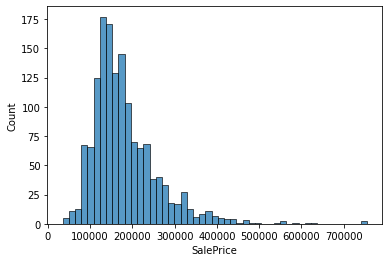

In [4]:
# visualizing data
sns.histplot(train_data['SalePrice'])
# sns.displot(data_train['SalePrice'], kind='hist')

# If the skewness is between -0.5 and 0.5, the data are fairly symmetrical
# If the skewness is between -1 and – 0.5 or between 0.5 and 1, the data are moderately skewed
# If the skewness is less than -1 or greater than 1, the data are highly skewed
print(train_data['SalePrice'].skew())

<AxesSubplot:>

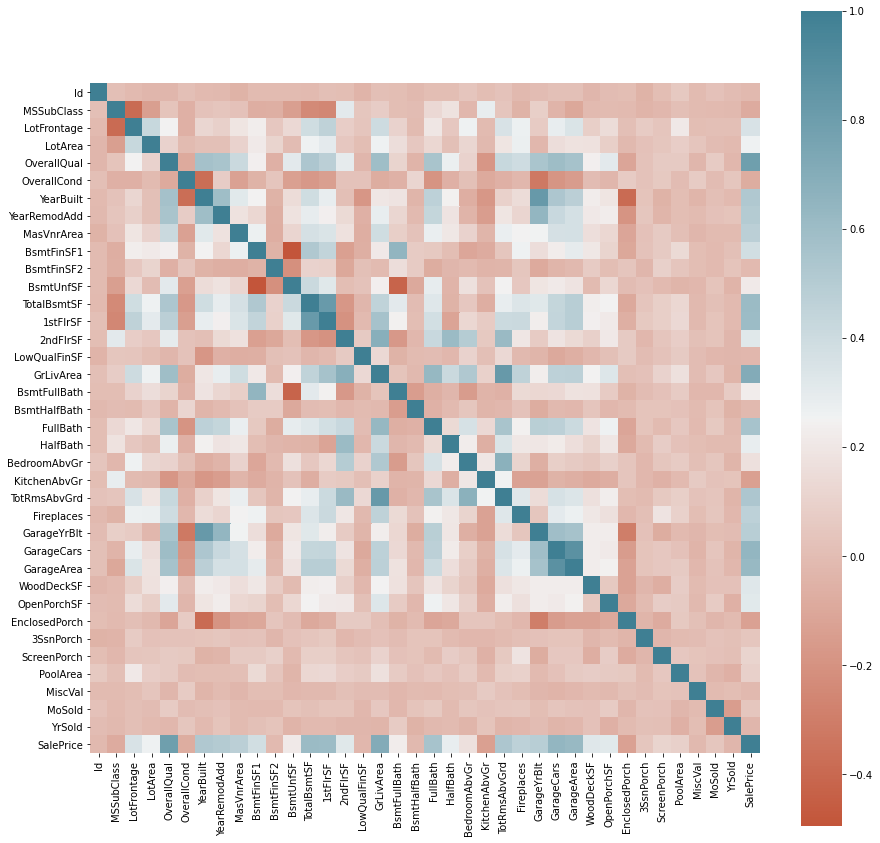

In [5]:
# -1 indicates a perfectly negative linear correlation between two variables
# 0 indicates no linear correlation between two variables
# 1 indicates a perfectly positive linear correlation between two variables

corrmat = train_data.corr()
plt.figure(figsize=(15, 15))
color_scheme = sns.diverging_palette(20, 220, n=200, as_cmap=True)
sns.heatmap(corrmat, cmap=color_scheme, square=True)

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')


<AxesSubplot:>

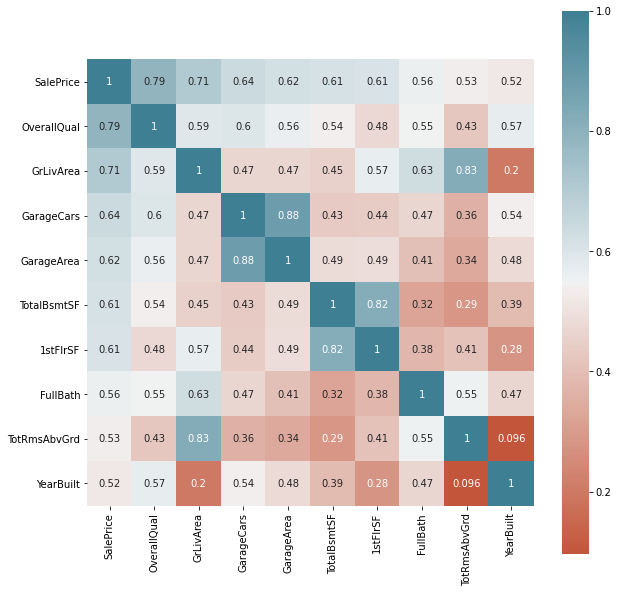

In [6]:
# based on the correlation heatmap, the sale price is more dependent on the following:
#    1. OverallQual
#    2. GrLiveArea
#    3. GarageCars
#    4. GarageArea
#    5. TotalBsmtSF
#    6. 1stFlrSF
# creating a correlation heatmap with these values
cols = corrmat.nlargest(10, 'SalePrice').index
print(cols)
new_cormat = np.corrcoef(train_data[cols].to_numpy().T)

plt.figure(figsize=(10, 10))
sns.heatmap(new_cormat, cmap=color_scheme, annot=True, square=True,
            yticklabels=cols.values, xticklabels=cols.values)

<AxesSubplot:xlabel='Neighborhood', ylabel='SalePrice'>

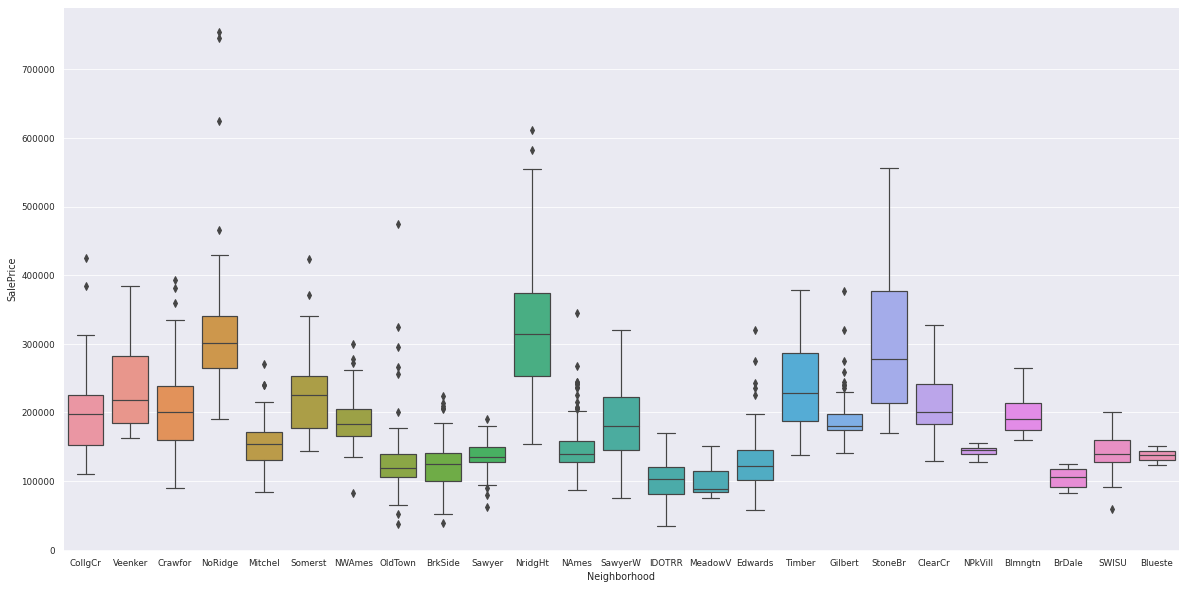

In [7]:
# plotting SalePrice vs Neighbourhood(location)
sns.set(rc={'figure.figsize': (20, 10)})
sns.set_context('paper')
sns.boxplot(x='Neighborhood', y='SalePrice', data=train_data)
# data_train['Neighborhood'].unique()
# data_train[data_train['Neighborhood'] == 'NoRidge']['SalePrice'].describe()

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

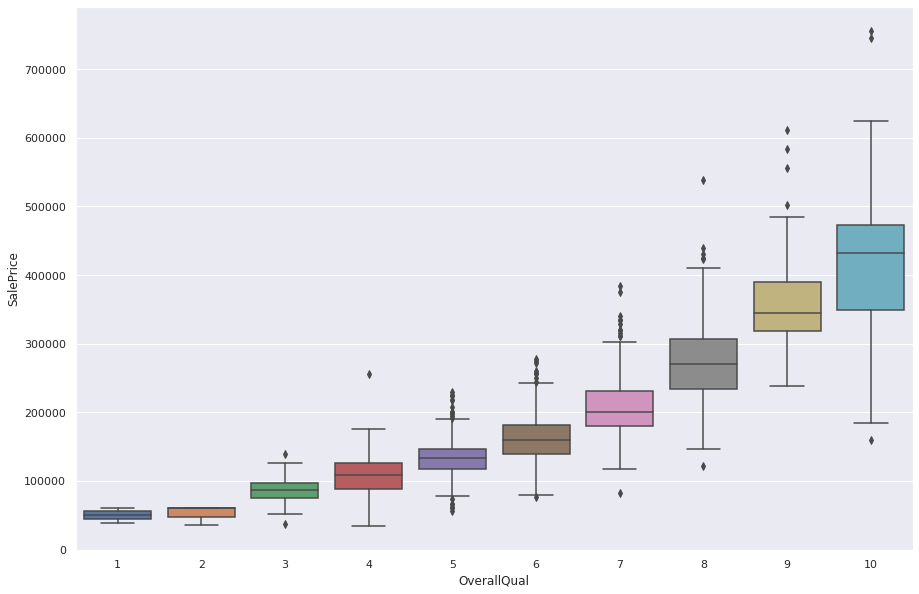

In [8]:
# plotting SalePrice vs OverallQual
sns.set(rc={'figure.figsize': (15, 10)})
sns.boxplot(x='OverallQual', y='SalePrice', data=train_data)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


1298    5642
523     4676
1182    4476
691     4316
Name: GrLivArea, dtype: int64


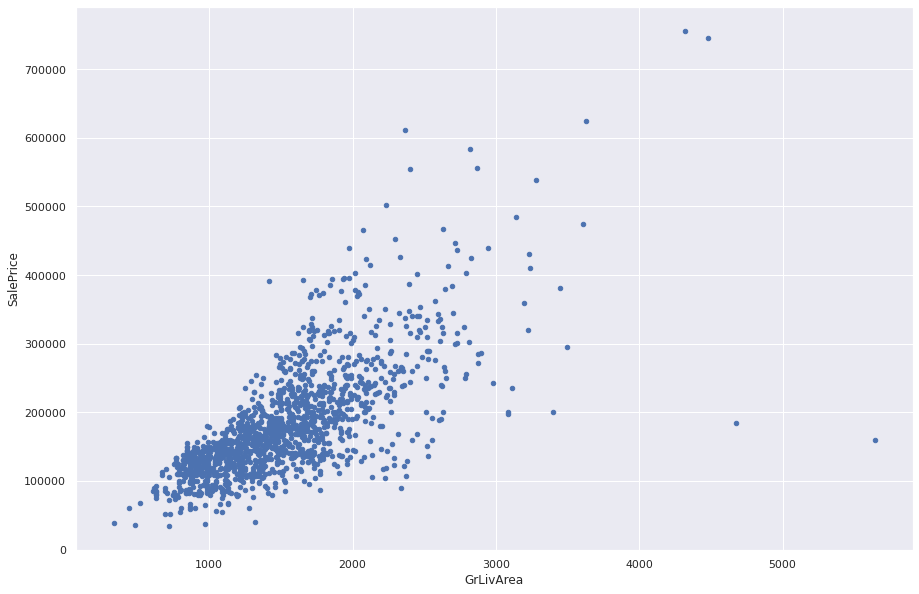

In [9]:
# plotting data to outliers and remove
train_data.plot.scatter(x='GrLivArea', y='SalePrice')
# 2 outliers in the rightmost bottom
print(train_data['GrLivArea'].sort_values(ascending=False)[:4])
train_data = train_data.drop(train_data[train_data['GrLivArea'] > 4476].index)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

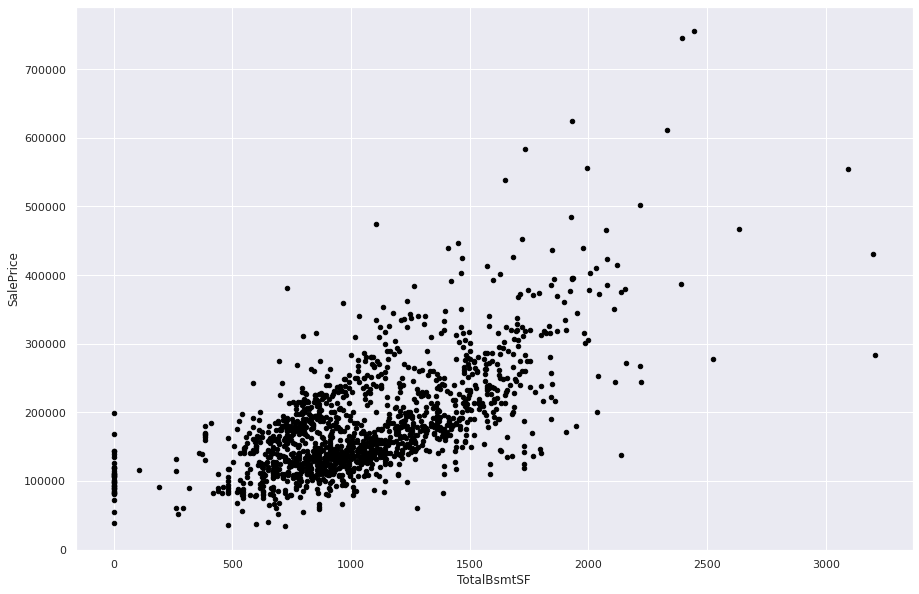

In [10]:
train_data.plot.scatter(x='TotalBsmtSF', y='SalePrice', c='black')
# 1 outliers TotalBsmtSF > 3000

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

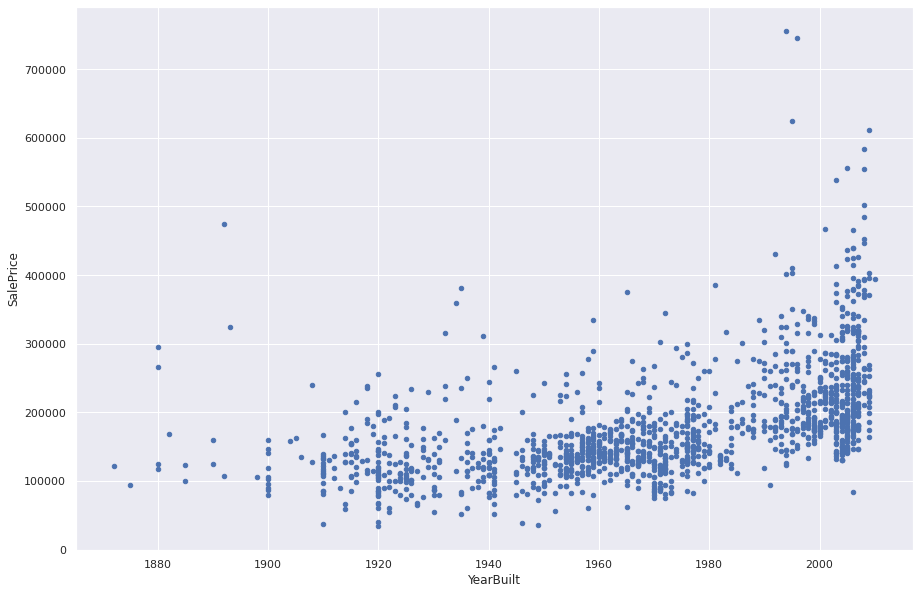

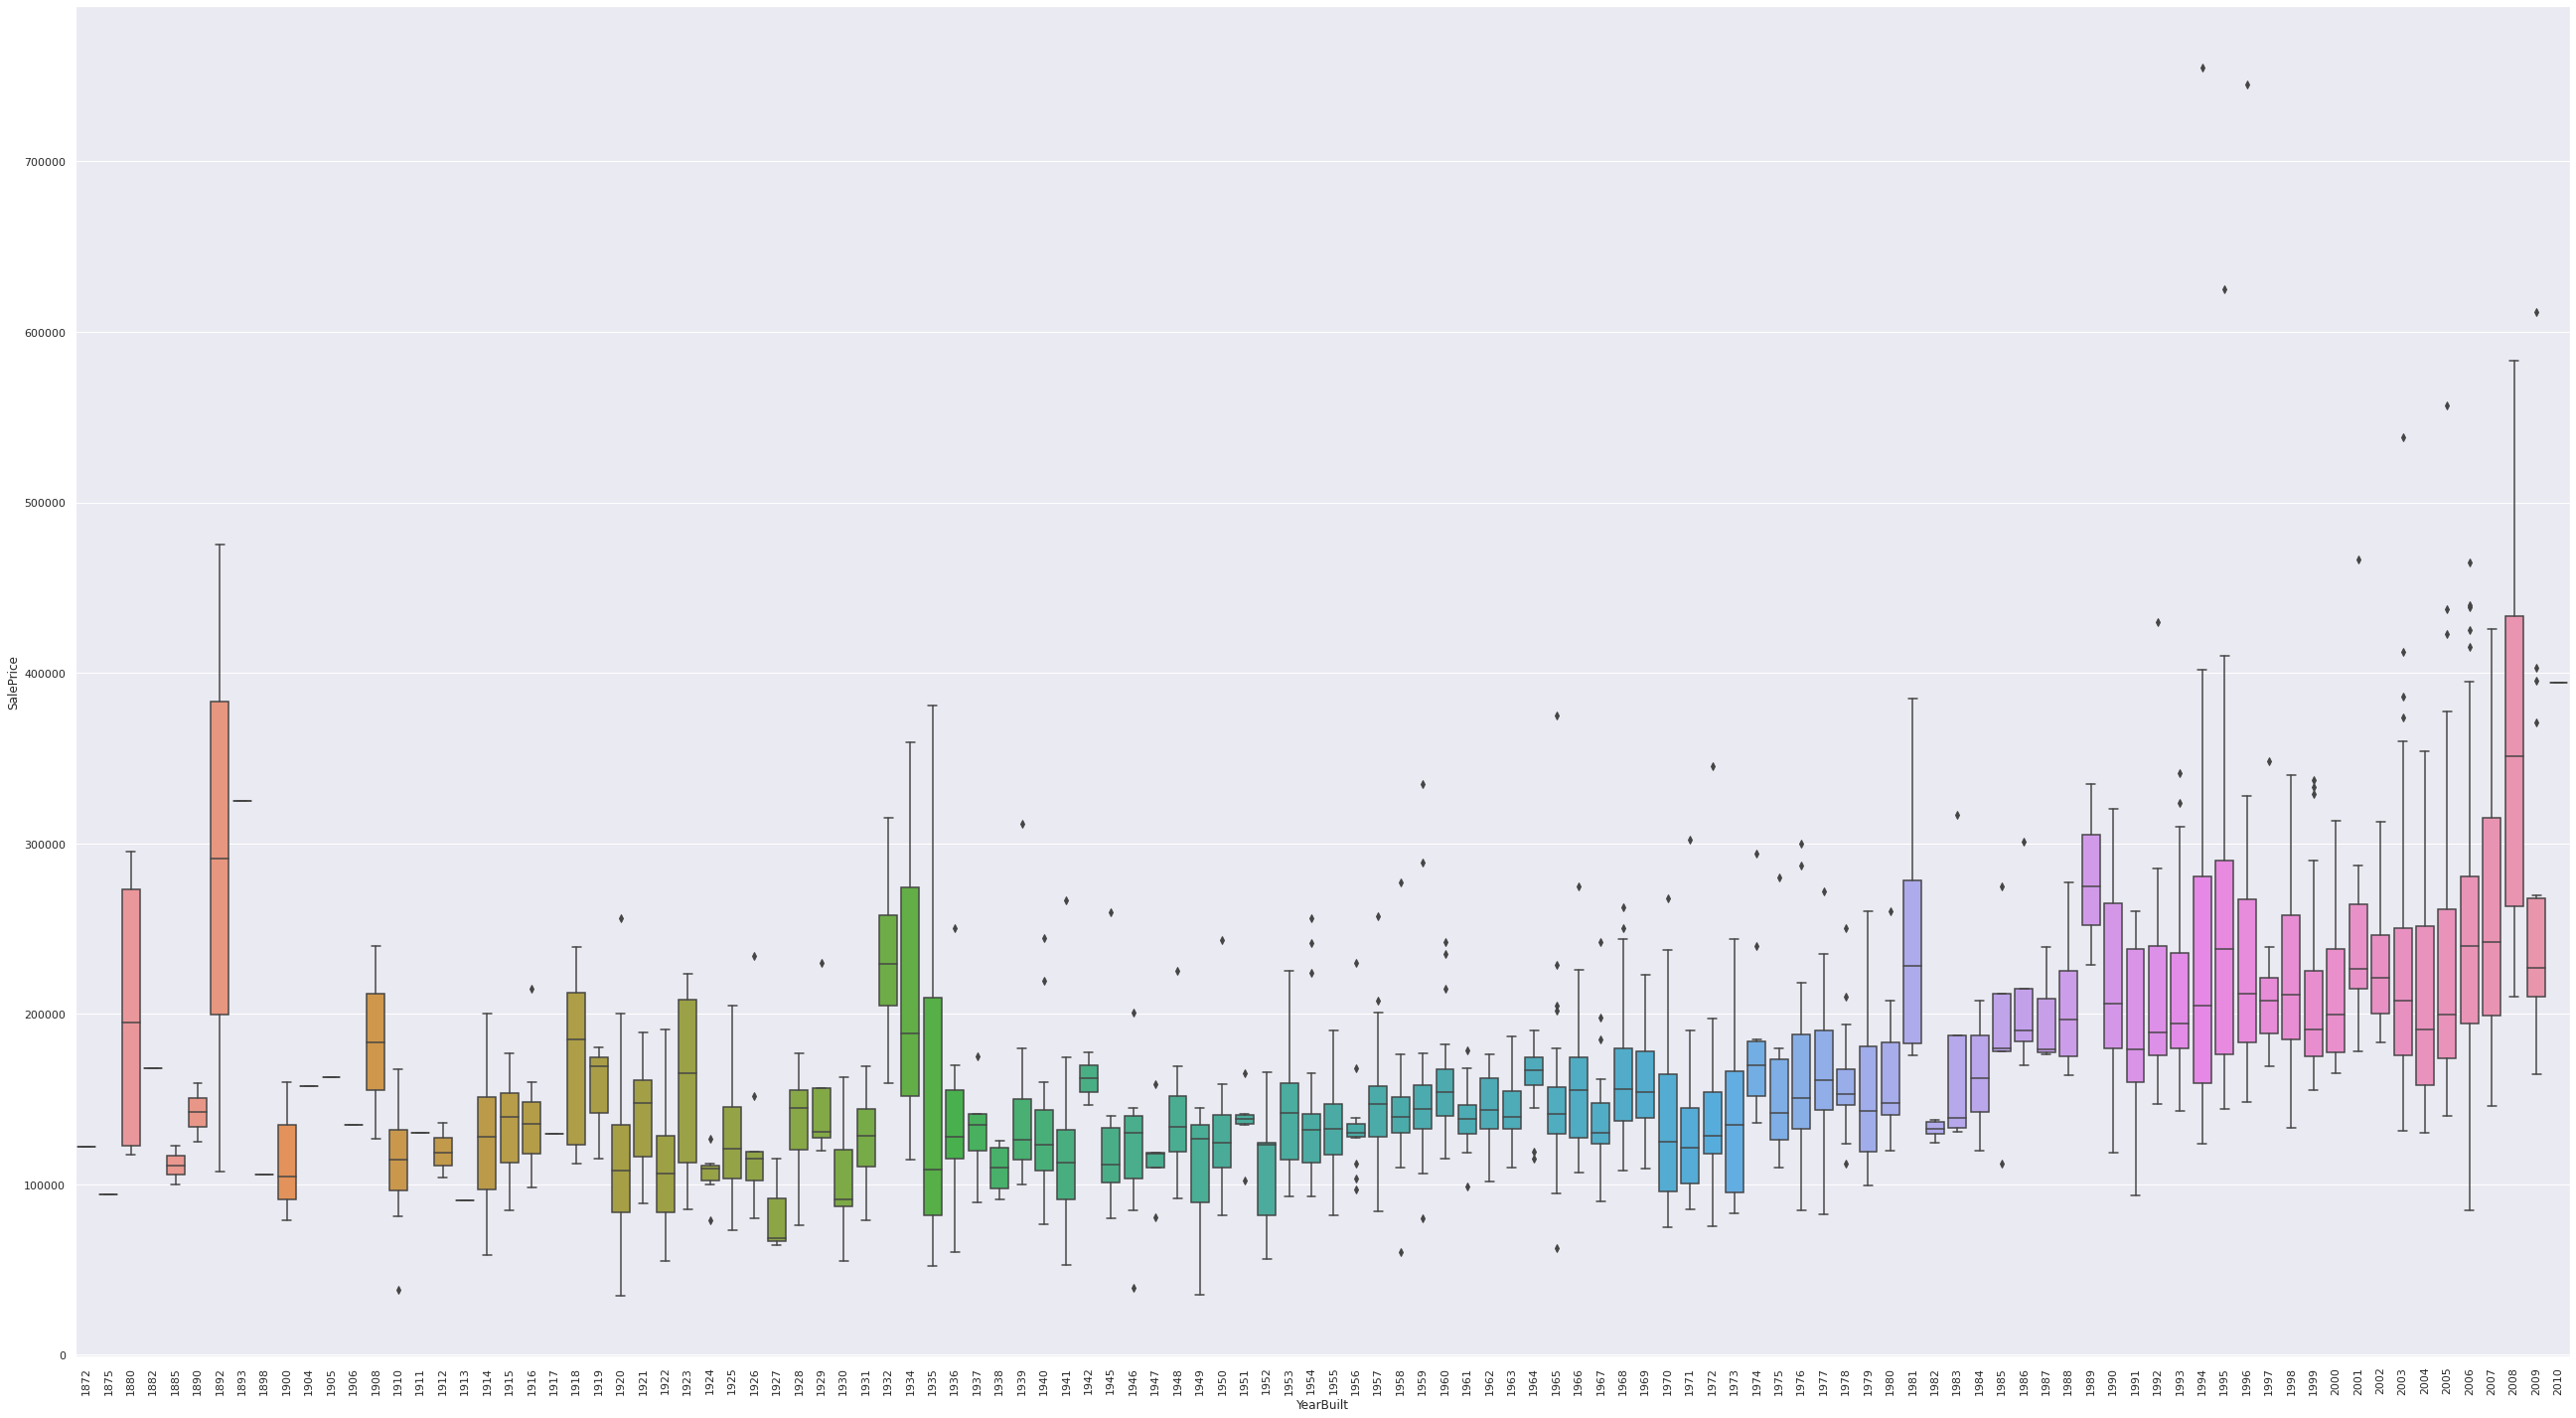

In [11]:
train_data.plot.scatter(x='YearBuilt', y='SalePrice')
plt.figure(figsize=(45, 25))
plt.xticks(rotation=90)
sns.boxplot(x='YearBuilt', y='SalePrice', data=train_data)

In [12]:
# dropping outliers with SalePrice > 600000 and YearBuilt > 1993
train_data = train_data.drop(train_data[np.logical_and(
    (train_data['YearBuilt'] > 1993), (train_data['SalePrice'] > 600000))].index)

In [13]:
numeric_features = train_data.dtypes[train_data.dtypes != 'object'].index
skewed_data = train_data[numeric_features].skew().sort_values(ascending=False)
print(skewed_data.head(20))

MiscVal          24.426632
PoolArea         17.510482
LotArea          12.659863
3SsnPorch        10.282620
LowQualFinSF      8.992169
KitchenAbvGr      4.477847
BsmtFinSF2        4.245246
BsmtHalfBath      4.125654
ScreenPorch       4.112351
EnclosedPorch     3.081741
MasVnrArea        2.547162
OpenPorchSF       2.340498
WoodDeckSF        1.554856
LotFrontage       1.545946
SalePrice         1.425757
MSSubClass        1.405317
BsmtUnfSF         0.920522
1stFlrSF          0.861141
GrLivArea         0.807402
2ndFlrSF          0.766149
dtype: float64


In [14]:
# taking a look at the missing(null) data
all_data = pd.concat([train_data, test_data], ignore_index=True)

is_null = (all_data[all_data.columns.drop('SalePrice')]).isnull()
missing_total = is_null.sum().sort_values(ascending=False)
missing_total = missing_total[missing_total>0]
missing_percentage = (is_null.sum() * 100 / is_null.count()
                      ).sort_values(ascending=False)
missing_percentage = missing_percentage[missing_percentage>0]
missing_cols = pd.concat([missing_total, missing_percentage], keys=[
                         'Total', 'Percentage'], axis=1)
print(missing_cols.shape)
missing_cols.head(35)

(34, 2)


,Total,Percentage
PoolQC,2905,99.725369
MiscFeature,2808,96.395469
Alley,2715,93.202884
Fence,2343,80.432544
FireplaceQu,1420,48.746996
LotFrontage,486,16.683831
GarageYrBlt,159,5.458290
GarageFinish,159,5.458290
GarageQual,159,5.458290
GarageCond,159,5.458290


In [15]:
all_data = all_data.drop(
    columns=missing_cols[missing_cols['Percentage'] > 15].index)
# checking there are no missing values
print(all_data.shape)
print(all_data[all_data.columns.drop('SalePrice')].isnull().sum().max())

(2913, 75)
159


In [16]:
for col in ['GarageYrBlt', 'GarageCars', 'GarageArea']:
    all_data[col] = all_data[col].fillna(0)

In [17]:
for col in ['GarageFinish', 'GarageQual', 'GarageCond', 'GarageType']:
    all_data[col] = all_data[col].fillna('None')

In [18]:
for col in ['BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF', 'BsmtHalfBath', 'BsmtFullBath']:
    all_data[col] = all_data[col].fillna(0)

In [19]:
for col in ['BsmtFinType1', 'BsmtFinType2', 'BsmtQual', 'BsmtCond', 'BsmtExposure']:
    all_data[col] = all_data[col].fillna('None')

In [20]:
all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

In [21]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [22]:
# all data are same ('AllPub') except one 'NoSeWa' and 2 'NA', so we'll drop this column
all_data = all_data.drop(columns='Utilities')

In [23]:
all_data["Functional"] = all_data["Functional"].fillna("Typ")

In [24]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

In [25]:
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

In [26]:
for col in ['Exterior1st', 'Exterior2nd']:
    all_data[col] = all_data[col].fillna(all_data[col].mode()[0])

In [27]:
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

In [28]:
# applying log transformation on the data
# sns.distplot(saleprice_scaled, fit=norm)
# plt.figure()
# sns.distplot(boxcox(data_train['SalePrice'])[0], fit=norm)
# plt.figure()
# probplot(boxcox(data_train['SalePrice'])[0], plot=plt)
train_index = all_data.apply(pd.Series.last_valid_index)['SalePrice']
print(train_index)

1453


In [29]:
all_data = pd.get_dummies(all_data)
train_data = all_data.loc[:train_index]
y_train = train_data['SalePrice']
x_train = train_data.drop(columns='SalePrice')
x_test = all_data.loc[train_index+1:]
x_test = x_test.drop(columns='SalePrice')
x_test.reset_index(drop=True, inplace=True)

In [30]:
print(y_train.isnull().sum())
print(y_train.shape, x_train.shape, x_test.shape)

0
(1454,) (1454, 276) (1459, 276)


In [31]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

lasso = Lasso(alpha=0.1)
linear = LinearRegression()
elasticnet = ElasticNet()

lasso.fit(x_train, y_train)
linear.fit(x_train, y_train)
elasticnet.fit(x_train, y_train)

ElasticNet()

In [32]:
sub = pd.DataFrame()
sub['Id'] = test_data['Id']
for model in [lasso, linear, elasticnet]:
    sub['SalePrice'] = model.predict(x_test)
    sub.to_csv('submissions/{}.csv'.format(model.__class__.__name__), index=False)